# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

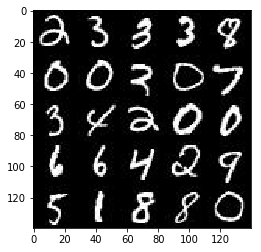

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

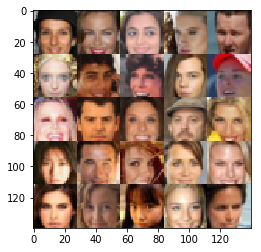

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    r_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='r_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    lr = tf.placeholder(dtype=tf.float32, name='learning_rate')

    return r_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        h1 = tf.layers.batch_normalization(h1, training=True)
        h1 = tf.maximum(0.2 * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(0.2 * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(0.2 * h3, h3)
        
        flat = tf.contrib.layers.flatten(h3)
        
        drop = tf.nn.dropout(x=flat, keep_prob=0.8)
        logits = tf.layers.dense(drop, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        h1 = tf.layers.dense(z, 5*5*512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        h1 = tf.reshape(h1, (-1, 5, 5, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(0.2 * h1, h1)
        
        h2 = tf.layers.conv2d_transpose(h1, 256, kernel_size=5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(0.2 * h2, h2)
        
        h3 = tf.layers.conv2d_transpose(h2, 256, kernel_size=5, strides=1, padding='valid',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(0.2 * h3, h3)
        
        
        h4 = tf.layers.conv2d_transpose(h3, 128, kernel_size=5, strides=1, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        h4 = tf.layers.batch_normalization(h4, training=is_train)
        h4 = tf.maximum(0.2 * h4, h4)
        
        drop = tf.nn.dropout(x=h4, keep_prob=0.5)
        logits = tf.layers.conv2d_transpose(drop, out_channel_dim, kernel_size=5,strides=2, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=tf.ones_like(d_model_real)*0.9))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_step = 20
    show_step = 100
    images_to_show = 9
    losses =[]
    step = 0

    _, width, height, channels = data_shape
    
    r_input, z_input, lr = model_inputs(width, height, channels, z_dim)
    
    d_loss, g_loss = model_loss(r_input, z_input, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images = 2*batch_images
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={r_input: batch_images, z_input: z_batch, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: z_batch, r_input: batch_images, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: z_batch, r_input: batch_images, lr: learning_rate})
                
                if step % print_step == 0:
                    train_loss_d = d_loss.eval({z_input: z_batch, r_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_batch})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Step: {}:".format(step),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if step % show_step == 0:
                    show_generator_output(sess, images_to_show, z_input, channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step: 20: Discriminator Loss: 1.8919... Generator Loss: 0.5923
Epoch 1/2... Step: 40: Discriminator Loss: 2.6301... Generator Loss: 0.8018
Epoch 1/2... Step: 60: Discriminator Loss: 1.7584... Generator Loss: 0.6974
Epoch 1/2... Step: 80: Discriminator Loss: 2.3112... Generator Loss: 0.9543
Epoch 1/2... Step: 100: Discriminator Loss: 1.7434... Generator Loss: 1.0437


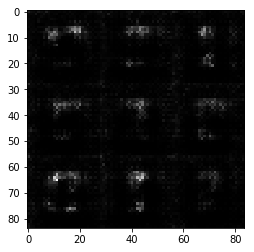

Epoch 1/2... Step: 120: Discriminator Loss: 1.3420... Generator Loss: 0.8291
Epoch 1/2... Step: 140: Discriminator Loss: 1.5831... Generator Loss: 0.6272
Epoch 1/2... Step: 160: Discriminator Loss: 1.6022... Generator Loss: 0.6794
Epoch 1/2... Step: 180: Discriminator Loss: 1.7698... Generator Loss: 0.6313
Epoch 1/2... Step: 200: Discriminator Loss: 1.8534... Generator Loss: 0.7337


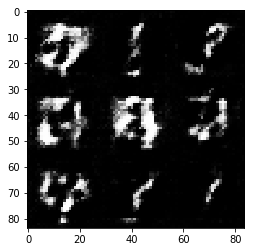

Epoch 1/2... Step: 220: Discriminator Loss: 1.6504... Generator Loss: 0.7128
Epoch 1/2... Step: 240: Discriminator Loss: 1.3482... Generator Loss: 1.1253
Epoch 1/2... Step: 260: Discriminator Loss: 1.3786... Generator Loss: 0.8388
Epoch 1/2... Step: 280: Discriminator Loss: 1.8761... Generator Loss: 0.3640
Epoch 1/2... Step: 300: Discriminator Loss: 1.5886... Generator Loss: 0.5705


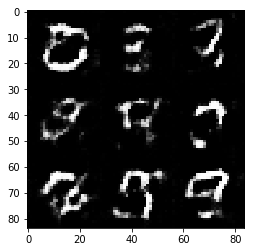

Epoch 1/2... Step: 320: Discriminator Loss: 1.3420... Generator Loss: 0.8431
Epoch 1/2... Step: 340: Discriminator Loss: 1.5465... Generator Loss: 0.7268
Epoch 1/2... Step: 360: Discriminator Loss: 1.7490... Generator Loss: 0.5940
Epoch 1/2... Step: 380: Discriminator Loss: 1.6003... Generator Loss: 0.4940
Epoch 1/2... Step: 400: Discriminator Loss: 1.6638... Generator Loss: 1.1117


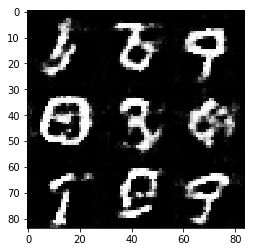

Epoch 1/2... Step: 420: Discriminator Loss: 1.5715... Generator Loss: 0.4715
Epoch 1/2... Step: 440: Discriminator Loss: 1.4539... Generator Loss: 0.5855
Epoch 1/2... Step: 460: Discriminator Loss: 1.3959... Generator Loss: 0.9394
Epoch 1/2... Step: 480: Discriminator Loss: 1.4482... Generator Loss: 0.8319
Epoch 1/2... Step: 500: Discriminator Loss: 1.4806... Generator Loss: 0.5358


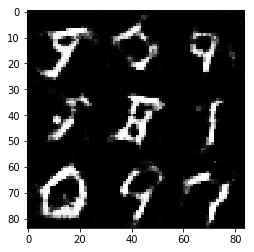

Epoch 1/2... Step: 520: Discriminator Loss: 1.7372... Generator Loss: 0.6315
Epoch 1/2... Step: 540: Discriminator Loss: 1.4240... Generator Loss: 0.8647
Epoch 1/2... Step: 560: Discriminator Loss: 1.4619... Generator Loss: 0.8913
Epoch 1/2... Step: 580: Discriminator Loss: 1.6452... Generator Loss: 1.2702
Epoch 1/2... Step: 600: Discriminator Loss: 1.6439... Generator Loss: 0.6277


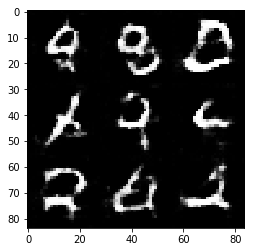

Epoch 1/2... Step: 620: Discriminator Loss: 1.5750... Generator Loss: 0.9838
Epoch 1/2... Step: 640: Discriminator Loss: 1.4762... Generator Loss: 1.2591
Epoch 1/2... Step: 660: Discriminator Loss: 1.4677... Generator Loss: 0.5282
Epoch 1/2... Step: 680: Discriminator Loss: 1.4738... Generator Loss: 0.6264
Epoch 1/2... Step: 700: Discriminator Loss: 1.6472... Generator Loss: 0.4454


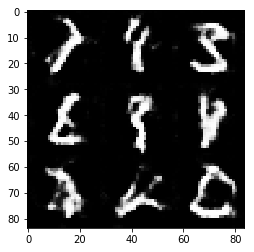

Epoch 1/2... Step: 720: Discriminator Loss: 1.3967... Generator Loss: 0.6805
Epoch 1/2... Step: 740: Discriminator Loss: 1.4754... Generator Loss: 0.8966
Epoch 1/2... Step: 760: Discriminator Loss: 1.3649... Generator Loss: 0.7286
Epoch 1/2... Step: 780: Discriminator Loss: 1.3884... Generator Loss: 0.7446
Epoch 1/2... Step: 800: Discriminator Loss: 1.6402... Generator Loss: 0.6561


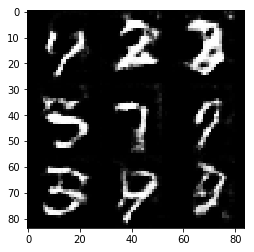

Epoch 1/2... Step: 820: Discriminator Loss: 1.4062... Generator Loss: 0.8251
Epoch 1/2... Step: 840: Discriminator Loss: 1.6490... Generator Loss: 0.5506
Epoch 1/2... Step: 860: Discriminator Loss: 1.4292... Generator Loss: 0.6852
Epoch 1/2... Step: 880: Discriminator Loss: 1.3862... Generator Loss: 0.5883
Epoch 1/2... Step: 900: Discriminator Loss: 1.3915... Generator Loss: 0.6359


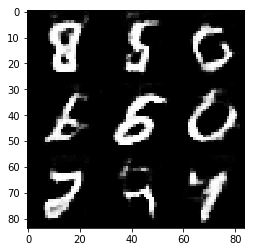

Epoch 1/2... Step: 920: Discriminator Loss: 1.4539... Generator Loss: 0.4988
Epoch 1/2... Step: 940: Discriminator Loss: 1.3463... Generator Loss: 0.9455
Epoch 1/2... Step: 960: Discriminator Loss: 1.4066... Generator Loss: 0.5602
Epoch 1/2... Step: 980: Discriminator Loss: 1.4085... Generator Loss: 0.6159
Epoch 1/2... Step: 1000: Discriminator Loss: 1.4314... Generator Loss: 1.1958


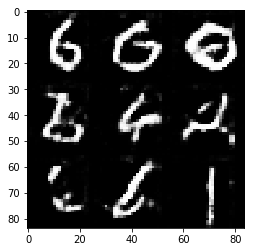

Epoch 1/2... Step: 1020: Discriminator Loss: 1.4199... Generator Loss: 0.6597
Epoch 1/2... Step: 1040: Discriminator Loss: 1.4009... Generator Loss: 0.5146
Epoch 1/2... Step: 1060: Discriminator Loss: 1.4381... Generator Loss: 0.7693
Epoch 1/2... Step: 1080: Discriminator Loss: 1.2708... Generator Loss: 0.5668
Epoch 1/2... Step: 1100: Discriminator Loss: 1.4492... Generator Loss: 0.5456


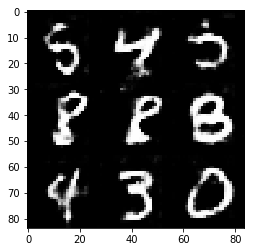

Epoch 1/2... Step: 1120: Discriminator Loss: 1.3827... Generator Loss: 0.6899
Epoch 1/2... Step: 1140: Discriminator Loss: 1.6204... Generator Loss: 0.3496
Epoch 1/2... Step: 1160: Discriminator Loss: 1.3852... Generator Loss: 0.7644
Epoch 1/2... Step: 1180: Discriminator Loss: 1.2512... Generator Loss: 0.7459
Epoch 1/2... Step: 1200: Discriminator Loss: 1.1486... Generator Loss: 0.9847


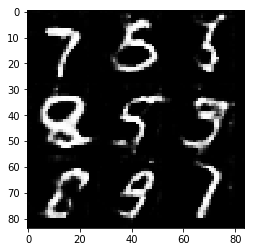

Epoch 1/2... Step: 1220: Discriminator Loss: 1.3089... Generator Loss: 0.9350
Epoch 1/2... Step: 1240: Discriminator Loss: 1.6038... Generator Loss: 1.2747
Epoch 1/2... Step: 1260: Discriminator Loss: 1.3537... Generator Loss: 0.7263
Epoch 1/2... Step: 1280: Discriminator Loss: 1.6352... Generator Loss: 1.2929
Epoch 1/2... Step: 1300: Discriminator Loss: 1.3260... Generator Loss: 0.7675


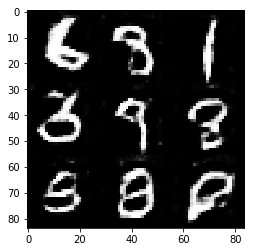

Epoch 1/2... Step: 1320: Discriminator Loss: 1.3878... Generator Loss: 0.9169
Epoch 1/2... Step: 1340: Discriminator Loss: 1.3419... Generator Loss: 0.9375
Epoch 1/2... Step: 1360: Discriminator Loss: 1.2000... Generator Loss: 0.9714
Epoch 1/2... Step: 1380: Discriminator Loss: 1.3286... Generator Loss: 0.6710
Epoch 1/2... Step: 1400: Discriminator Loss: 1.2656... Generator Loss: 0.8691


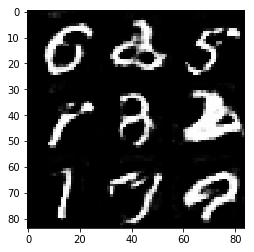

Epoch 1/2... Step: 1420: Discriminator Loss: 1.3230... Generator Loss: 0.8700
Epoch 1/2... Step: 1440: Discriminator Loss: 1.5458... Generator Loss: 0.6141
Epoch 1/2... Step: 1460: Discriminator Loss: 1.4487... Generator Loss: 0.7046
Epoch 1/2... Step: 1480: Discriminator Loss: 1.5578... Generator Loss: 0.5056
Epoch 1/2... Step: 1500: Discriminator Loss: 1.2023... Generator Loss: 0.8305


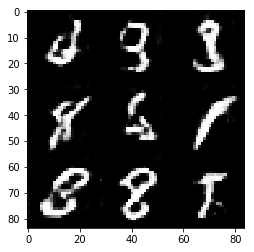

Epoch 1/2... Step: 1520: Discriminator Loss: 1.3654... Generator Loss: 1.1621
Epoch 1/2... Step: 1540: Discriminator Loss: 1.1648... Generator Loss: 0.8194
Epoch 1/2... Step: 1560: Discriminator Loss: 1.2973... Generator Loss: 0.8045
Epoch 1/2... Step: 1580: Discriminator Loss: 1.2090... Generator Loss: 1.0068
Epoch 1/2... Step: 1600: Discriminator Loss: 1.3386... Generator Loss: 0.9956


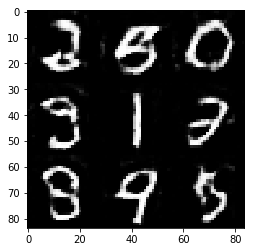

Epoch 1/2... Step: 1620: Discriminator Loss: 1.3772... Generator Loss: 0.6233
Epoch 1/2... Step: 1640: Discriminator Loss: 1.2111... Generator Loss: 1.0116
Epoch 1/2... Step: 1660: Discriminator Loss: 2.2804... Generator Loss: 2.2471
Epoch 1/2... Step: 1680: Discriminator Loss: 1.1921... Generator Loss: 0.9445
Epoch 1/2... Step: 1700: Discriminator Loss: 1.2265... Generator Loss: 0.8225


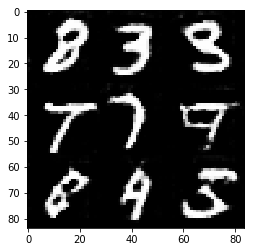

Epoch 1/2... Step: 1720: Discriminator Loss: 1.2160... Generator Loss: 0.9076
Epoch 1/2... Step: 1740: Discriminator Loss: 1.1819... Generator Loss: 0.8503
Epoch 1/2... Step: 1760: Discriminator Loss: 1.3177... Generator Loss: 1.1211
Epoch 1/2... Step: 1780: Discriminator Loss: 1.1453... Generator Loss: 0.9313
Epoch 1/2... Step: 1800: Discriminator Loss: 1.6661... Generator Loss: 0.3040


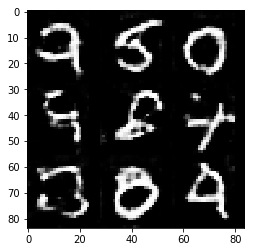

Epoch 1/2... Step: 1820: Discriminator Loss: 1.1983... Generator Loss: 0.8537
Epoch 1/2... Step: 1840: Discriminator Loss: 1.3318... Generator Loss: 0.9781
Epoch 1/2... Step: 1860: Discriminator Loss: 1.3145... Generator Loss: 0.5743
Epoch 2/2... Step: 1880: Discriminator Loss: 1.4408... Generator Loss: 0.5284
Epoch 2/2... Step: 1900: Discriminator Loss: 2.0571... Generator Loss: 0.2373


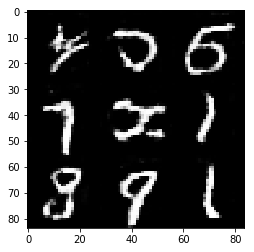

Epoch 2/2... Step: 1920: Discriminator Loss: 1.2135... Generator Loss: 1.1059
Epoch 2/2... Step: 1940: Discriminator Loss: 1.5000... Generator Loss: 0.4917
Epoch 2/2... Step: 1960: Discriminator Loss: 1.4403... Generator Loss: 0.5074
Epoch 2/2... Step: 1980: Discriminator Loss: 1.2457... Generator Loss: 0.7395
Epoch 2/2... Step: 2000: Discriminator Loss: 1.1057... Generator Loss: 1.1390


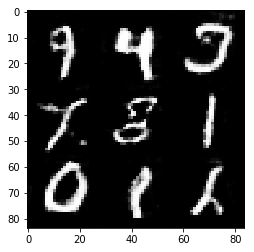

Epoch 2/2... Step: 2020: Discriminator Loss: 1.2592... Generator Loss: 0.5838
Epoch 2/2... Step: 2040: Discriminator Loss: 1.1194... Generator Loss: 0.7318
Epoch 2/2... Step: 2060: Discriminator Loss: 1.2346... Generator Loss: 0.6809
Epoch 2/2... Step: 2080: Discriminator Loss: 1.0783... Generator Loss: 0.7548
Epoch 2/2... Step: 2100: Discriminator Loss: 1.1248... Generator Loss: 1.0879


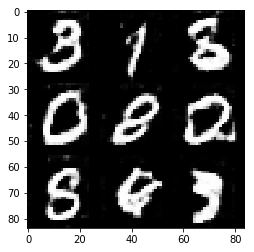

Epoch 2/2... Step: 2120: Discriminator Loss: 0.9624... Generator Loss: 1.1351
Epoch 2/2... Step: 2140: Discriminator Loss: 1.3934... Generator Loss: 0.5046
Epoch 2/2... Step: 2160: Discriminator Loss: 1.3158... Generator Loss: 0.6213
Epoch 2/2... Step: 2180: Discriminator Loss: 1.2521... Generator Loss: 0.7319
Epoch 2/2... Step: 2200: Discriminator Loss: 1.1549... Generator Loss: 1.3244


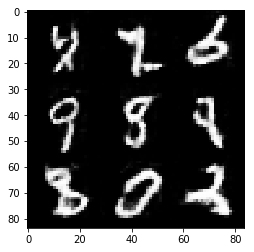

Epoch 2/2... Step: 2220: Discriminator Loss: 1.2171... Generator Loss: 0.8273
Epoch 2/2... Step: 2240: Discriminator Loss: 1.1308... Generator Loss: 1.4282
Epoch 2/2... Step: 2260: Discriminator Loss: 1.0727... Generator Loss: 1.0973
Epoch 2/2... Step: 2280: Discriminator Loss: 1.1714... Generator Loss: 0.8631
Epoch 2/2... Step: 2300: Discriminator Loss: 1.1087... Generator Loss: 0.9195


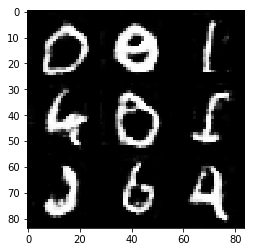

Epoch 2/2... Step: 2320: Discriminator Loss: 1.1105... Generator Loss: 1.0996
Epoch 2/2... Step: 2340: Discriminator Loss: 1.2023... Generator Loss: 1.0115
Epoch 2/2... Step: 2360: Discriminator Loss: 1.0872... Generator Loss: 1.4668
Epoch 2/2... Step: 2380: Discriminator Loss: 0.9883... Generator Loss: 1.1067
Epoch 2/2... Step: 2400: Discriminator Loss: 1.0572... Generator Loss: 1.2754


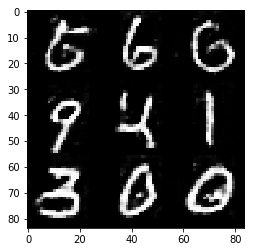

Epoch 2/2... Step: 2420: Discriminator Loss: 1.2290... Generator Loss: 1.1194
Epoch 2/2... Step: 2440: Discriminator Loss: 1.0100... Generator Loss: 0.8926
Epoch 2/2... Step: 2460: Discriminator Loss: 1.4241... Generator Loss: 0.4810
Epoch 2/2... Step: 2480: Discriminator Loss: 1.1658... Generator Loss: 0.7331
Epoch 2/2... Step: 2500: Discriminator Loss: 1.3121... Generator Loss: 1.0176


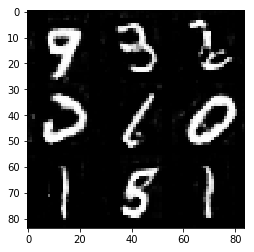

Epoch 2/2... Step: 2520: Discriminator Loss: 1.2069... Generator Loss: 0.5831
Epoch 2/2... Step: 2540: Discriminator Loss: 1.0801... Generator Loss: 1.1339
Epoch 2/2... Step: 2560: Discriminator Loss: 1.2595... Generator Loss: 1.1058
Epoch 2/2... Step: 2580: Discriminator Loss: 1.1294... Generator Loss: 1.0283
Epoch 2/2... Step: 2600: Discriminator Loss: 1.1828... Generator Loss: 0.8194


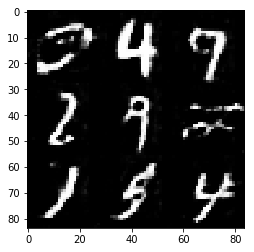

Epoch 2/2... Step: 2620: Discriminator Loss: 1.1730... Generator Loss: 0.9758
Epoch 2/2... Step: 2640: Discriminator Loss: 1.1701... Generator Loss: 0.9113
Epoch 2/2... Step: 2660: Discriminator Loss: 0.8823... Generator Loss: 1.0982
Epoch 2/2... Step: 2680: Discriminator Loss: 1.1841... Generator Loss: 1.0022
Epoch 2/2... Step: 2700: Discriminator Loss: 1.1202... Generator Loss: 1.0243


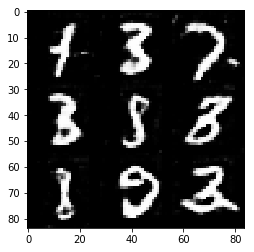

Epoch 2/2... Step: 2720: Discriminator Loss: 1.4695... Generator Loss: 0.5993
Epoch 2/2... Step: 2740: Discriminator Loss: 1.0591... Generator Loss: 1.2616
Epoch 2/2... Step: 2760: Discriminator Loss: 1.3211... Generator Loss: 0.5748
Epoch 2/2... Step: 2780: Discriminator Loss: 0.9529... Generator Loss: 0.9825
Epoch 2/2... Step: 2800: Discriminator Loss: 1.2095... Generator Loss: 0.7368


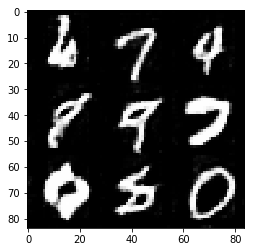

Epoch 2/2... Step: 2820: Discriminator Loss: 1.1862... Generator Loss: 0.7631
Epoch 2/2... Step: 2840: Discriminator Loss: 1.3293... Generator Loss: 0.8380
Epoch 2/2... Step: 2860: Discriminator Loss: 1.1300... Generator Loss: 0.9162
Epoch 2/2... Step: 2880: Discriminator Loss: 1.0308... Generator Loss: 0.8681
Epoch 2/2... Step: 2900: Discriminator Loss: 1.4246... Generator Loss: 0.4906


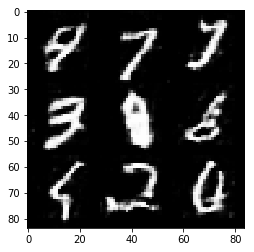

Epoch 2/2... Step: 2920: Discriminator Loss: 1.1184... Generator Loss: 1.0249
Epoch 2/2... Step: 2940: Discriminator Loss: 1.1474... Generator Loss: 1.0451
Epoch 2/2... Step: 2960: Discriminator Loss: 1.0728... Generator Loss: 1.0073
Epoch 2/2... Step: 2980: Discriminator Loss: 1.4059... Generator Loss: 0.9267
Epoch 2/2... Step: 3000: Discriminator Loss: 0.8684... Generator Loss: 1.2498


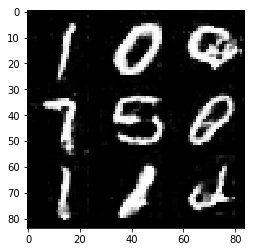

Epoch 2/2... Step: 3020: Discriminator Loss: 1.1425... Generator Loss: 0.7613
Epoch 2/2... Step: 3040: Discriminator Loss: 1.1754... Generator Loss: 0.7062
Epoch 2/2... Step: 3060: Discriminator Loss: 1.3521... Generator Loss: 0.5839
Epoch 2/2... Step: 3080: Discriminator Loss: 1.2615... Generator Loss: 0.7899
Epoch 2/2... Step: 3100: Discriminator Loss: 1.2006... Generator Loss: 0.8758


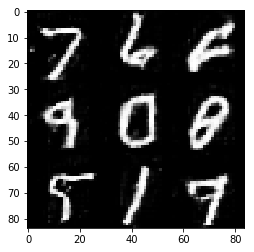

Epoch 2/2... Step: 3120: Discriminator Loss: 1.0041... Generator Loss: 1.1330
Epoch 2/2... Step: 3140: Discriminator Loss: 1.1023... Generator Loss: 0.9851
Epoch 2/2... Step: 3160: Discriminator Loss: 1.1359... Generator Loss: 0.8143
Epoch 2/2... Step: 3180: Discriminator Loss: 1.2559... Generator Loss: 0.5596
Epoch 2/2... Step: 3200: Discriminator Loss: 1.2363... Generator Loss: 0.7720


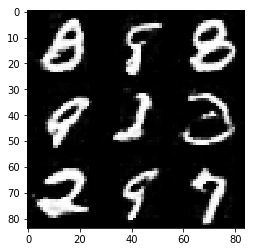

Epoch 2/2... Step: 3220: Discriminator Loss: 1.1570... Generator Loss: 0.8604
Epoch 2/2... Step: 3240: Discriminator Loss: 1.1892... Generator Loss: 0.7479
Epoch 2/2... Step: 3260: Discriminator Loss: 1.5455... Generator Loss: 0.7711
Epoch 2/2... Step: 3280: Discriminator Loss: 1.4063... Generator Loss: 0.5366
Epoch 2/2... Step: 3300: Discriminator Loss: 1.4162... Generator Loss: 0.5355


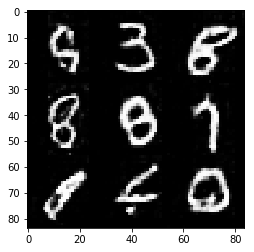

Epoch 2/2... Step: 3320: Discriminator Loss: 1.1900... Generator Loss: 0.7540
Epoch 2/2... Step: 3340: Discriminator Loss: 1.0089... Generator Loss: 0.9778
Epoch 2/2... Step: 3360: Discriminator Loss: 0.9167... Generator Loss: 1.2781
Epoch 2/2... Step: 3380: Discriminator Loss: 0.9355... Generator Loss: 1.4361
Epoch 2/2... Step: 3400: Discriminator Loss: 1.1409... Generator Loss: 0.9075


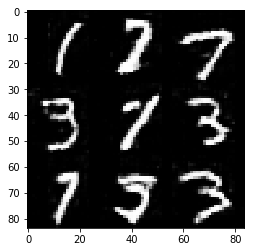

Epoch 2/2... Step: 3420: Discriminator Loss: 1.1860... Generator Loss: 0.6924
Epoch 2/2... Step: 3440: Discriminator Loss: 1.0334... Generator Loss: 0.8870
Epoch 2/2... Step: 3460: Discriminator Loss: 0.9274... Generator Loss: 1.4079
Epoch 2/2... Step: 3480: Discriminator Loss: 1.0087... Generator Loss: 1.0196
Epoch 2/2... Step: 3500: Discriminator Loss: 1.2604... Generator Loss: 0.7655


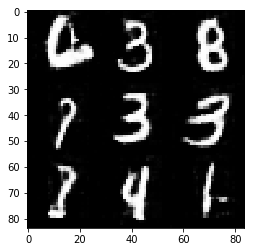

Epoch 2/2... Step: 3520: Discriminator Loss: 1.0628... Generator Loss: 1.2613
Epoch 2/2... Step: 3540: Discriminator Loss: 1.5938... Generator Loss: 0.5092
Epoch 2/2... Step: 3560: Discriminator Loss: 1.1541... Generator Loss: 0.8446
Epoch 2/2... Step: 3580: Discriminator Loss: 0.9496... Generator Loss: 1.2426
Epoch 2/2... Step: 3600: Discriminator Loss: 1.1645... Generator Loss: 0.6797


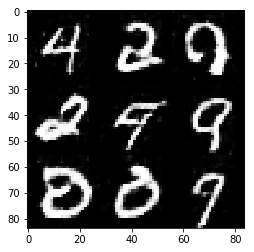

Epoch 2/2... Step: 3620: Discriminator Loss: 1.0261... Generator Loss: 1.6116
Epoch 2/2... Step: 3640: Discriminator Loss: 0.9946... Generator Loss: 1.0657
Epoch 2/2... Step: 3660: Discriminator Loss: 1.2457... Generator Loss: 0.8308
Epoch 2/2... Step: 3680: Discriminator Loss: 1.0356... Generator Loss: 1.7448
Epoch 2/2... Step: 3700: Discriminator Loss: 1.2097... Generator Loss: 0.9854


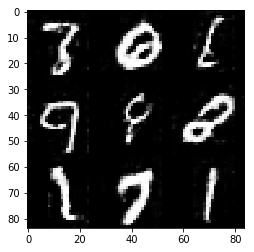

Epoch 2/2... Step: 3720: Discriminator Loss: 1.5432... Generator Loss: 1.8796
Epoch 2/2... Step: 3740: Discriminator Loss: 1.2902... Generator Loss: 0.7976


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step: 20: Discriminator Loss: 2.2218... Generator Loss: 0.4386
Epoch 1/1... Step: 40: Discriminator Loss: 2.1944... Generator Loss: 1.4089
Epoch 1/1... Step: 60: Discriminator Loss: 1.5435... Generator Loss: 2.5626
Epoch 1/1... Step: 80: Discriminator Loss: 0.9244... Generator Loss: 1.7184
Epoch 1/1... Step: 100: Discriminator Loss: 0.8350... Generator Loss: 1.5458


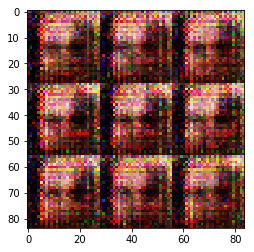

Epoch 1/1... Step: 120: Discriminator Loss: 1.0533... Generator Loss: 1.6252
Epoch 1/1... Step: 140: Discriminator Loss: 1.0101... Generator Loss: 1.0198
Epoch 1/1... Step: 160: Discriminator Loss: 0.9323... Generator Loss: 1.0882
Epoch 1/1... Step: 180: Discriminator Loss: 1.4521... Generator Loss: 0.8242
Epoch 1/1... Step: 200: Discriminator Loss: 1.1757... Generator Loss: 0.7136


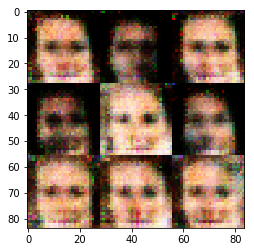

Epoch 1/1... Step: 220: Discriminator Loss: 0.9535... Generator Loss: 1.1143
Epoch 1/1... Step: 240: Discriminator Loss: 1.3578... Generator Loss: 0.7862
Epoch 1/1... Step: 260: Discriminator Loss: 1.5706... Generator Loss: 0.8571
Epoch 1/1... Step: 280: Discriminator Loss: 1.4439... Generator Loss: 0.8205
Epoch 1/1... Step: 300: Discriminator Loss: 1.3628... Generator Loss: 1.0446


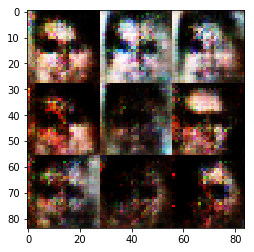

Epoch 1/1... Step: 320: Discriminator Loss: 1.8966... Generator Loss: 0.4905
Epoch 1/1... Step: 340: Discriminator Loss: 1.5901... Generator Loss: 0.6035
Epoch 1/1... Step: 360: Discriminator Loss: 1.6733... Generator Loss: 0.5560
Epoch 1/1... Step: 380: Discriminator Loss: 1.6134... Generator Loss: 0.6298
Epoch 1/1... Step: 400: Discriminator Loss: 1.5531... Generator Loss: 0.7039


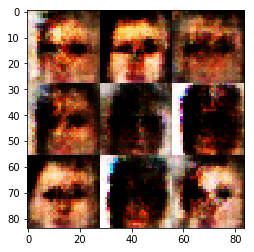

Epoch 1/1... Step: 420: Discriminator Loss: 1.8446... Generator Loss: 0.7184
Epoch 1/1... Step: 440: Discriminator Loss: 1.5366... Generator Loss: 0.6767
Epoch 1/1... Step: 460: Discriminator Loss: 1.7774... Generator Loss: 0.6555
Epoch 1/1... Step: 480: Discriminator Loss: 1.6402... Generator Loss: 0.6061
Epoch 1/1... Step: 500: Discriminator Loss: 1.4917... Generator Loss: 0.7822


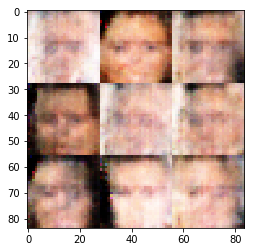

Epoch 1/1... Step: 520: Discriminator Loss: 1.6888... Generator Loss: 0.6379
Epoch 1/1... Step: 540: Discriminator Loss: 1.7031... Generator Loss: 0.6678
Epoch 1/1... Step: 560: Discriminator Loss: 1.6594... Generator Loss: 0.7394
Epoch 1/1... Step: 580: Discriminator Loss: 1.4327... Generator Loss: 0.8087
Epoch 1/1... Step: 600: Discriminator Loss: 1.4778... Generator Loss: 0.7051


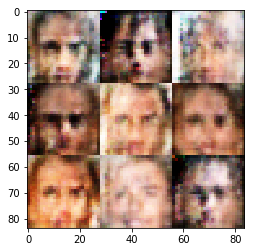

Epoch 1/1... Step: 620: Discriminator Loss: 1.5652... Generator Loss: 0.8094
Epoch 1/1... Step: 640: Discriminator Loss: 1.4999... Generator Loss: 0.7724
Epoch 1/1... Step: 660: Discriminator Loss: 1.5673... Generator Loss: 0.6867
Epoch 1/1... Step: 680: Discriminator Loss: 1.6904... Generator Loss: 0.7448
Epoch 1/1... Step: 700: Discriminator Loss: 1.5990... Generator Loss: 0.6314


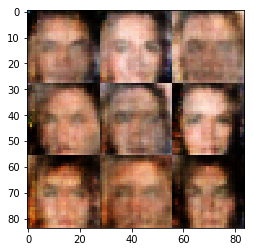

Epoch 1/1... Step: 720: Discriminator Loss: 1.4145... Generator Loss: 0.7501
Epoch 1/1... Step: 740: Discriminator Loss: 1.5174... Generator Loss: 0.6273
Epoch 1/1... Step: 760: Discriminator Loss: 1.5535... Generator Loss: 0.7696
Epoch 1/1... Step: 780: Discriminator Loss: 1.5584... Generator Loss: 0.6775
Epoch 1/1... Step: 800: Discriminator Loss: 1.6652... Generator Loss: 0.6856


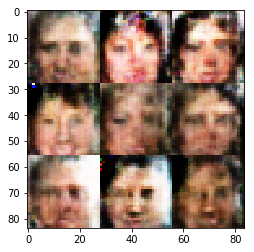

Epoch 1/1... Step: 820: Discriminator Loss: 1.4947... Generator Loss: 0.7796
Epoch 1/1... Step: 840: Discriminator Loss: 1.4267... Generator Loss: 0.8593
Epoch 1/1... Step: 860: Discriminator Loss: 1.4526... Generator Loss: 0.6665
Epoch 1/1... Step: 880: Discriminator Loss: 1.4166... Generator Loss: 0.8418
Epoch 1/1... Step: 900: Discriminator Loss: 1.5635... Generator Loss: 0.5921


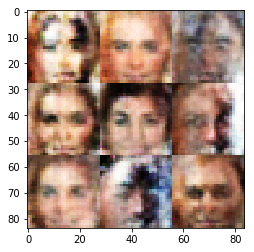

Epoch 1/1... Step: 920: Discriminator Loss: 1.4149... Generator Loss: 0.6735
Epoch 1/1... Step: 940: Discriminator Loss: 1.5690... Generator Loss: 0.6783
Epoch 1/1... Step: 960: Discriminator Loss: 1.5281... Generator Loss: 0.7127
Epoch 1/1... Step: 980: Discriminator Loss: 1.5924... Generator Loss: 0.7176
Epoch 1/1... Step: 1000: Discriminator Loss: 1.3550... Generator Loss: 0.7799


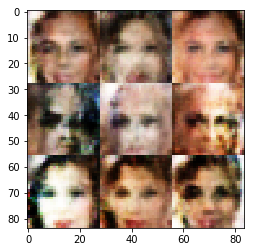

Epoch 1/1... Step: 1020: Discriminator Loss: 1.4377... Generator Loss: 0.7128
Epoch 1/1... Step: 1040: Discriminator Loss: 1.4493... Generator Loss: 0.7402
Epoch 1/1... Step: 1060: Discriminator Loss: 1.5062... Generator Loss: 0.8573
Epoch 1/1... Step: 1080: Discriminator Loss: 1.5318... Generator Loss: 0.7375
Epoch 1/1... Step: 1100: Discriminator Loss: 1.4640... Generator Loss: 0.7130


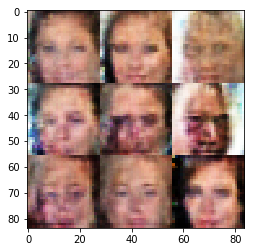

Epoch 1/1... Step: 1120: Discriminator Loss: 1.4575... Generator Loss: 0.8153
Epoch 1/1... Step: 1140: Discriminator Loss: 1.4193... Generator Loss: 0.8460
Epoch 1/1... Step: 1160: Discriminator Loss: 1.4261... Generator Loss: 0.6725
Epoch 1/1... Step: 1180: Discriminator Loss: 1.4481... Generator Loss: 0.7639
Epoch 1/1... Step: 1200: Discriminator Loss: 1.4362... Generator Loss: 0.7679


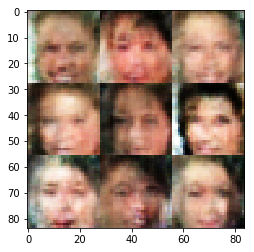

Epoch 1/1... Step: 1220: Discriminator Loss: 1.4955... Generator Loss: 0.6269
Epoch 1/1... Step: 1240: Discriminator Loss: 1.4255... Generator Loss: 0.7333
Epoch 1/1... Step: 1260: Discriminator Loss: 1.3778... Generator Loss: 0.7612
Epoch 1/1... Step: 1280: Discriminator Loss: 1.4496... Generator Loss: 0.7719
Epoch 1/1... Step: 1300: Discriminator Loss: 1.6253... Generator Loss: 0.7670


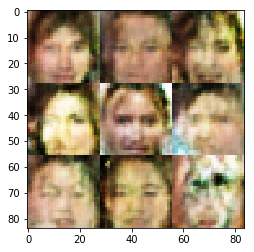

Epoch 1/1... Step: 1320: Discriminator Loss: 1.4162... Generator Loss: 0.8180
Epoch 1/1... Step: 1340: Discriminator Loss: 1.4423... Generator Loss: 0.7643
Epoch 1/1... Step: 1360: Discriminator Loss: 1.5471... Generator Loss: 0.7692
Epoch 1/1... Step: 1380: Discriminator Loss: 1.5614... Generator Loss: 0.7074
Epoch 1/1... Step: 1400: Discriminator Loss: 1.5077... Generator Loss: 0.7181


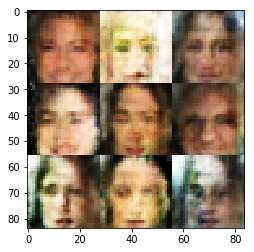

Epoch 1/1... Step: 1420: Discriminator Loss: 1.5189... Generator Loss: 0.6728
Epoch 1/1... Step: 1440: Discriminator Loss: 1.4555... Generator Loss: 0.7640
Epoch 1/1... Step: 1460: Discriminator Loss: 1.5686... Generator Loss: 0.6850
Epoch 1/1... Step: 1480: Discriminator Loss: 1.4230... Generator Loss: 0.8142
Epoch 1/1... Step: 1500: Discriminator Loss: 1.4516... Generator Loss: 0.7004


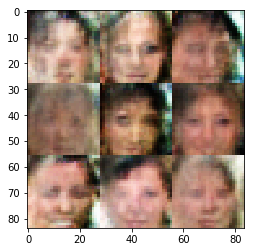

Epoch 1/1... Step: 1520: Discriminator Loss: 1.4905... Generator Loss: 0.7683
Epoch 1/1... Step: 1540: Discriminator Loss: 1.4202... Generator Loss: 0.7581
Epoch 1/1... Step: 1560: Discriminator Loss: 1.4623... Generator Loss: 0.7489
Epoch 1/1... Step: 1580: Discriminator Loss: 1.4726... Generator Loss: 0.7932
Epoch 1/1... Step: 1600: Discriminator Loss: 1.4539... Generator Loss: 0.8058


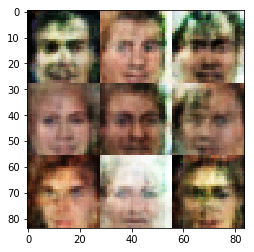

Epoch 1/1... Step: 1620: Discriminator Loss: 1.4857... Generator Loss: 0.7654
Epoch 1/1... Step: 1640: Discriminator Loss: 1.3813... Generator Loss: 0.7174
Epoch 1/1... Step: 1660: Discriminator Loss: 1.3842... Generator Loss: 0.7876
Epoch 1/1... Step: 1680: Discriminator Loss: 1.4437... Generator Loss: 0.7994
Epoch 1/1... Step: 1700: Discriminator Loss: 1.4563... Generator Loss: 0.7409


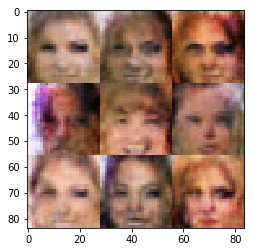

Epoch 1/1... Step: 1720: Discriminator Loss: 1.4509... Generator Loss: 0.7638
Epoch 1/1... Step: 1740: Discriminator Loss: 1.4259... Generator Loss: 0.7965
Epoch 1/1... Step: 1760: Discriminator Loss: 1.4223... Generator Loss: 0.8353
Epoch 1/1... Step: 1780: Discriminator Loss: 1.4392... Generator Loss: 0.7619
Epoch 1/1... Step: 1800: Discriminator Loss: 1.4371... Generator Loss: 0.7896


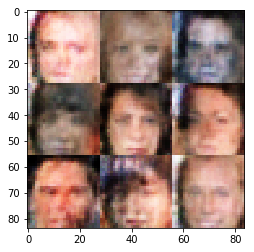

Epoch 1/1... Step: 1820: Discriminator Loss: 1.4365... Generator Loss: 0.7173
Epoch 1/1... Step: 1840: Discriminator Loss: 1.4537... Generator Loss: 0.7456
Epoch 1/1... Step: 1860: Discriminator Loss: 1.3699... Generator Loss: 0.7999
Epoch 1/1... Step: 1880: Discriminator Loss: 1.3908... Generator Loss: 0.7751
Epoch 1/1... Step: 1900: Discriminator Loss: 1.4292... Generator Loss: 0.7335


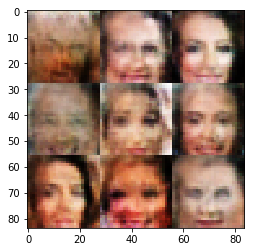

Epoch 1/1... Step: 1920: Discriminator Loss: 1.4147... Generator Loss: 0.8141
Epoch 1/1... Step: 1940: Discriminator Loss: 1.4700... Generator Loss: 0.7463
Epoch 1/1... Step: 1960: Discriminator Loss: 1.4629... Generator Loss: 0.7374
Epoch 1/1... Step: 1980: Discriminator Loss: 1.4543... Generator Loss: 0.7647
Epoch 1/1... Step: 2000: Discriminator Loss: 1.4997... Generator Loss: 0.7250


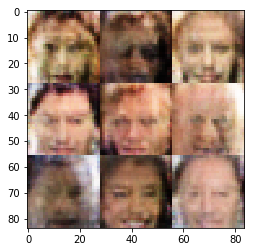

Epoch 1/1... Step: 2020: Discriminator Loss: 1.4493... Generator Loss: 0.7645
Epoch 1/1... Step: 2040: Discriminator Loss: 1.4404... Generator Loss: 0.7869
Epoch 1/1... Step: 2060: Discriminator Loss: 1.3917... Generator Loss: 0.7787
Epoch 1/1... Step: 2080: Discriminator Loss: 1.4045... Generator Loss: 0.7539
Epoch 1/1... Step: 2100: Discriminator Loss: 1.4529... Generator Loss: 0.7987


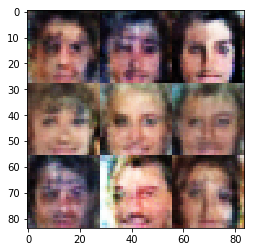

Epoch 1/1... Step: 2120: Discriminator Loss: 1.4234... Generator Loss: 0.8001
Epoch 1/1... Step: 2140: Discriminator Loss: 1.4574... Generator Loss: 0.7324
Epoch 1/1... Step: 2160: Discriminator Loss: 1.4498... Generator Loss: 0.7383
Epoch 1/1... Step: 2180: Discriminator Loss: 1.4745... Generator Loss: 0.7595
Epoch 1/1... Step: 2200: Discriminator Loss: 1.4367... Generator Loss: 0.6949


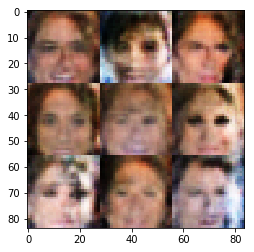

Epoch 1/1... Step: 2220: Discriminator Loss: 1.4586... Generator Loss: 0.7444
Epoch 1/1... Step: 2240: Discriminator Loss: 1.3962... Generator Loss: 0.7552
Epoch 1/1... Step: 2260: Discriminator Loss: 1.5142... Generator Loss: 0.7627
Epoch 1/1... Step: 2280: Discriminator Loss: 1.3829... Generator Loss: 0.8639
Epoch 1/1... Step: 2300: Discriminator Loss: 1.4450... Generator Loss: 0.7984


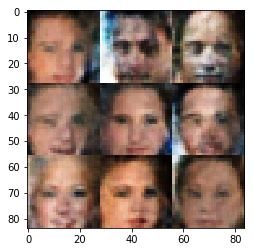

Epoch 1/1... Step: 2320: Discriminator Loss: 1.3898... Generator Loss: 0.7219
Epoch 1/1... Step: 2340: Discriminator Loss: 1.3557... Generator Loss: 0.7927
Epoch 1/1... Step: 2360: Discriminator Loss: 1.4123... Generator Loss: 0.8163
Epoch 1/1... Step: 2380: Discriminator Loss: 1.4513... Generator Loss: 0.7020
Epoch 1/1... Step: 2400: Discriminator Loss: 1.5064... Generator Loss: 0.7126


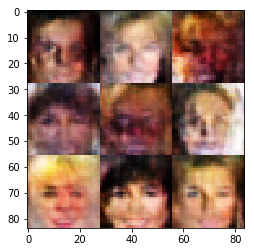

Epoch 1/1... Step: 2420: Discriminator Loss: 1.4398... Generator Loss: 0.7531
Epoch 1/1... Step: 2440: Discriminator Loss: 1.4428... Generator Loss: 0.7523
Epoch 1/1... Step: 2460: Discriminator Loss: 1.4345... Generator Loss: 0.8134
Epoch 1/1... Step: 2480: Discriminator Loss: 1.4339... Generator Loss: 0.7894
Epoch 1/1... Step: 2500: Discriminator Loss: 1.4362... Generator Loss: 0.7543


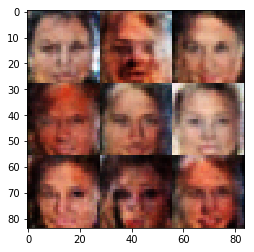

Epoch 1/1... Step: 2520: Discriminator Loss: 1.4391... Generator Loss: 0.7505
Epoch 1/1... Step: 2540: Discriminator Loss: 1.4128... Generator Loss: 0.8275
Epoch 1/1... Step: 2560: Discriminator Loss: 1.4274... Generator Loss: 0.7921
Epoch 1/1... Step: 2580: Discriminator Loss: 1.4721... Generator Loss: 0.7948
Epoch 1/1... Step: 2600: Discriminator Loss: 1.4505... Generator Loss: 0.8062


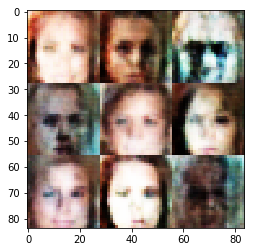

Epoch 1/1... Step: 2620: Discriminator Loss: 1.4161... Generator Loss: 0.7603
Epoch 1/1... Step: 2640: Discriminator Loss: 1.4695... Generator Loss: 0.7368
Epoch 1/1... Step: 2660: Discriminator Loss: 1.3710... Generator Loss: 0.7873
Epoch 1/1... Step: 2680: Discriminator Loss: 1.4023... Generator Loss: 0.7822
Epoch 1/1... Step: 2700: Discriminator Loss: 1.4247... Generator Loss: 0.7681


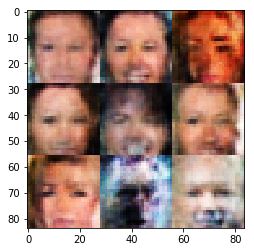

Epoch 1/1... Step: 2720: Discriminator Loss: 1.3931... Generator Loss: 0.8170
Epoch 1/1... Step: 2740: Discriminator Loss: 1.4064... Generator Loss: 0.7898
Epoch 1/1... Step: 2760: Discriminator Loss: 1.4098... Generator Loss: 0.7836
Epoch 1/1... Step: 2780: Discriminator Loss: 1.3632... Generator Loss: 0.8020
Epoch 1/1... Step: 2800: Discriminator Loss: 1.4270... Generator Loss: 0.7308


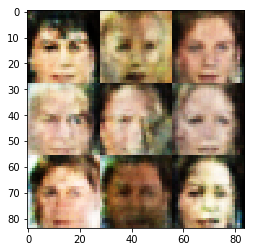

Epoch 1/1... Step: 2820: Discriminator Loss: 1.4181... Generator Loss: 0.7958
Epoch 1/1... Step: 2840: Discriminator Loss: 1.3672... Generator Loss: 0.7907
Epoch 1/1... Step: 2860: Discriminator Loss: 1.4125... Generator Loss: 0.7353
Epoch 1/1... Step: 2880: Discriminator Loss: 1.4570... Generator Loss: 0.7657
Epoch 1/1... Step: 2900: Discriminator Loss: 1.4337... Generator Loss: 0.7231


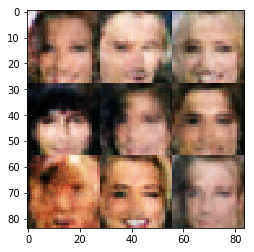

Epoch 1/1... Step: 2920: Discriminator Loss: 1.4105... Generator Loss: 0.7716
Epoch 1/1... Step: 2940: Discriminator Loss: 1.3868... Generator Loss: 0.8370
Epoch 1/1... Step: 2960: Discriminator Loss: 1.4040... Generator Loss: 0.7756
Epoch 1/1... Step: 2980: Discriminator Loss: 1.4230... Generator Loss: 0.7702
Epoch 1/1... Step: 3000: Discriminator Loss: 1.4618... Generator Loss: 0.7445


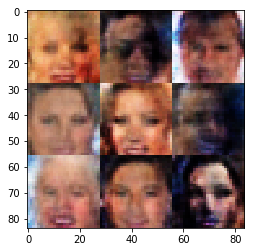

Epoch 1/1... Step: 3020: Discriminator Loss: 1.3946... Generator Loss: 0.8071
Epoch 1/1... Step: 3040: Discriminator Loss: 1.4227... Generator Loss: 0.7893
Epoch 1/1... Step: 3060: Discriminator Loss: 1.4246... Generator Loss: 0.7745
Epoch 1/1... Step: 3080: Discriminator Loss: 1.4145... Generator Loss: 0.7627
Epoch 1/1... Step: 3100: Discriminator Loss: 1.3995... Generator Loss: 0.7524


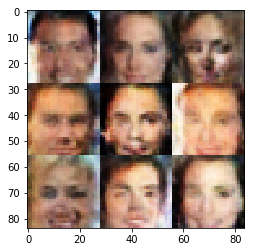

Epoch 1/1... Step: 3120: Discriminator Loss: 1.4360... Generator Loss: 0.7787
Epoch 1/1... Step: 3140: Discriminator Loss: 1.4071... Generator Loss: 0.7685
Epoch 1/1... Step: 3160: Discriminator Loss: 1.4525... Generator Loss: 0.7724
Epoch 1/1... Step: 3180: Discriminator Loss: 1.4463... Generator Loss: 0.8235
Epoch 1/1... Step: 3200: Discriminator Loss: 1.4335... Generator Loss: 0.7602


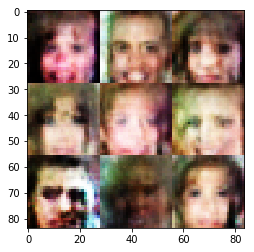

Epoch 1/1... Step: 3220: Discriminator Loss: 1.4231... Generator Loss: 0.7715
Epoch 1/1... Step: 3240: Discriminator Loss: 1.3951... Generator Loss: 0.7972
Epoch 1/1... Step: 3260: Discriminator Loss: 1.3875... Generator Loss: 0.7677
Epoch 1/1... Step: 3280: Discriminator Loss: 1.4311... Generator Loss: 0.7610
Epoch 1/1... Step: 3300: Discriminator Loss: 1.4268... Generator Loss: 0.7161


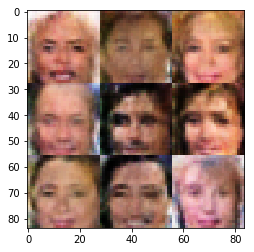

Epoch 1/1... Step: 3320: Discriminator Loss: 1.4330... Generator Loss: 0.7847
Epoch 1/1... Step: 3340: Discriminator Loss: 1.4213... Generator Loss: 0.7658
Epoch 1/1... Step: 3360: Discriminator Loss: 1.4162... Generator Loss: 0.7701
Epoch 1/1... Step: 3380: Discriminator Loss: 1.4361... Generator Loss: 0.8029
Epoch 1/1... Step: 3400: Discriminator Loss: 1.4832... Generator Loss: 0.7036


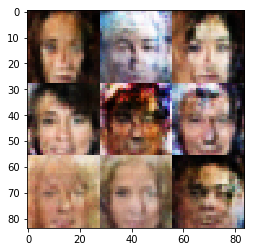

Epoch 1/1... Step: 3420: Discriminator Loss: 1.4207... Generator Loss: 0.7751
Epoch 1/1... Step: 3440: Discriminator Loss: 1.3882... Generator Loss: 0.7877
Epoch 1/1... Step: 3460: Discriminator Loss: 1.4257... Generator Loss: 0.7818
Epoch 1/1... Step: 3480: Discriminator Loss: 1.4007... Generator Loss: 0.8134
Epoch 1/1... Step: 3500: Discriminator Loss: 1.4282... Generator Loss: 0.7475


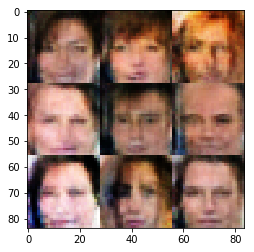

Epoch 1/1... Step: 3520: Discriminator Loss: 1.4693... Generator Loss: 0.7885
Epoch 1/1... Step: 3540: Discriminator Loss: 1.3709... Generator Loss: 0.8273
Epoch 1/1... Step: 3560: Discriminator Loss: 1.4698... Generator Loss: 0.7492
Epoch 1/1... Step: 3580: Discriminator Loss: 1.4040... Generator Loss: 0.7317
Epoch 1/1... Step: 3600: Discriminator Loss: 1.4071... Generator Loss: 0.7684


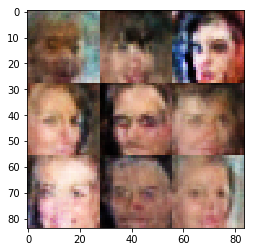

Epoch 1/1... Step: 3620: Discriminator Loss: 1.4119... Generator Loss: 0.7700
Epoch 1/1... Step: 3640: Discriminator Loss: 1.4200... Generator Loss: 0.7844
Epoch 1/1... Step: 3660: Discriminator Loss: 1.4213... Generator Loss: 0.8199
Epoch 1/1... Step: 3680: Discriminator Loss: 1.4108... Generator Loss: 0.7949
Epoch 1/1... Step: 3700: Discriminator Loss: 1.4301... Generator Loss: 0.7693


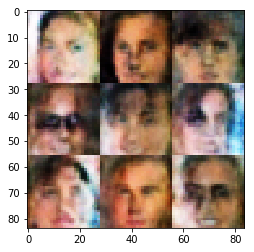

Epoch 1/1... Step: 3720: Discriminator Loss: 1.3939... Generator Loss: 0.7570
Epoch 1/1... Step: 3740: Discriminator Loss: 1.3881... Generator Loss: 0.7895
Epoch 1/1... Step: 3760: Discriminator Loss: 1.3790... Generator Loss: 0.7921
Epoch 1/1... Step: 3780: Discriminator Loss: 1.3532... Generator Loss: 0.8033
Epoch 1/1... Step: 3800: Discriminator Loss: 1.4391... Generator Loss: 0.7707


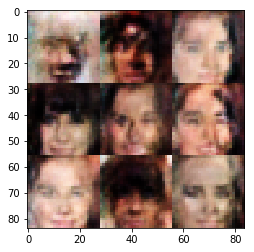

Epoch 1/1... Step: 3820: Discriminator Loss: 1.3975... Generator Loss: 0.7593
Epoch 1/1... Step: 3840: Discriminator Loss: 1.3905... Generator Loss: 0.7572
Epoch 1/1... Step: 3860: Discriminator Loss: 1.4112... Generator Loss: 0.7862
Epoch 1/1... Step: 3880: Discriminator Loss: 1.3865... Generator Loss: 0.8142
Epoch 1/1... Step: 3900: Discriminator Loss: 1.4089... Generator Loss: 0.8153


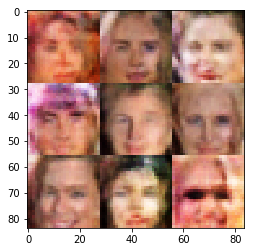

Epoch 1/1... Step: 3920: Discriminator Loss: 1.4181... Generator Loss: 0.7757
Epoch 1/1... Step: 3940: Discriminator Loss: 1.4010... Generator Loss: 0.7613
Epoch 1/1... Step: 3960: Discriminator Loss: 1.3938... Generator Loss: 0.8279
Epoch 1/1... Step: 3980: Discriminator Loss: 1.4498... Generator Loss: 0.7638
Epoch 1/1... Step: 4000: Discriminator Loss: 1.4114... Generator Loss: 0.8081


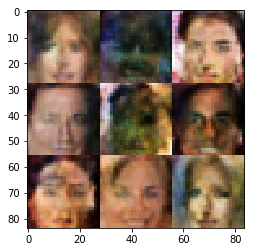

Epoch 1/1... Step: 4020: Discriminator Loss: 1.3685... Generator Loss: 0.8102
Epoch 1/1... Step: 4040: Discriminator Loss: 1.4116... Generator Loss: 0.7621
Epoch 1/1... Step: 4060: Discriminator Loss: 1.3957... Generator Loss: 0.7575
Epoch 1/1... Step: 4080: Discriminator Loss: 1.4021... Generator Loss: 0.7518
Epoch 1/1... Step: 4100: Discriminator Loss: 1.4342... Generator Loss: 0.7844


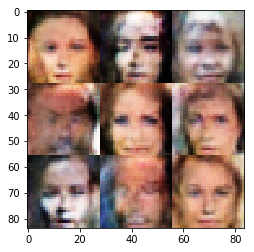

Epoch 1/1... Step: 4120: Discriminator Loss: 1.4025... Generator Loss: 0.8110
Epoch 1/1... Step: 4140: Discriminator Loss: 1.3957... Generator Loss: 0.7570
Epoch 1/1... Step: 4160: Discriminator Loss: 1.3693... Generator Loss: 0.8009
Epoch 1/1... Step: 4180: Discriminator Loss: 1.3999... Generator Loss: 0.7640
Epoch 1/1... Step: 4200: Discriminator Loss: 1.4512... Generator Loss: 0.7823


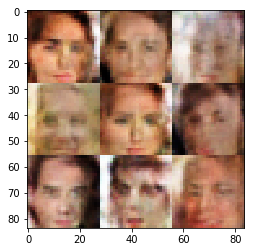

Epoch 1/1... Step: 4220: Discriminator Loss: 1.4219... Generator Loss: 0.7809
Epoch 1/1... Step: 4240: Discriminator Loss: 1.4407... Generator Loss: 0.7532
Epoch 1/1... Step: 4260: Discriminator Loss: 1.4175... Generator Loss: 0.7635
Epoch 1/1... Step: 4280: Discriminator Loss: 1.4114... Generator Loss: 0.7876
Epoch 1/1... Step: 4300: Discriminator Loss: 1.3897... Generator Loss: 0.7512


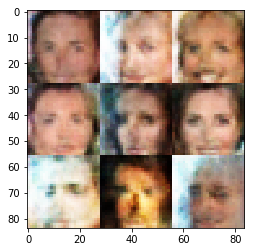

Epoch 1/1... Step: 4320: Discriminator Loss: 1.4267... Generator Loss: 0.7457
Epoch 1/1... Step: 4340: Discriminator Loss: 1.3853... Generator Loss: 0.7663
Epoch 1/1... Step: 4360: Discriminator Loss: 1.4138... Generator Loss: 0.8012
Epoch 1/1... Step: 4380: Discriminator Loss: 1.3775... Generator Loss: 0.7933
Epoch 1/1... Step: 4400: Discriminator Loss: 1.3917... Generator Loss: 0.7810


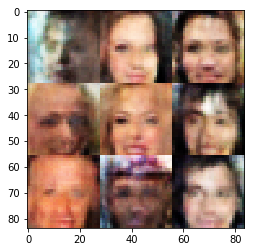

Epoch 1/1... Step: 4420: Discriminator Loss: 1.3827... Generator Loss: 0.7924
Epoch 1/1... Step: 4440: Discriminator Loss: 1.3832... Generator Loss: 0.7663
Epoch 1/1... Step: 4460: Discriminator Loss: 1.4232... Generator Loss: 0.7978
Epoch 1/1... Step: 4480: Discriminator Loss: 1.4079... Generator Loss: 0.8103
Epoch 1/1... Step: 4500: Discriminator Loss: 1.3968... Generator Loss: 0.8070


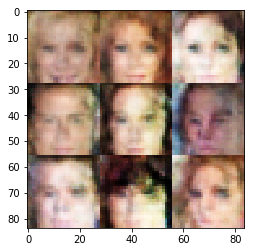

Epoch 1/1... Step: 4520: Discriminator Loss: 1.3728... Generator Loss: 0.7711
Epoch 1/1... Step: 4540: Discriminator Loss: 1.3872... Generator Loss: 0.8052
Epoch 1/1... Step: 4560: Discriminator Loss: 1.3683... Generator Loss: 0.7297
Epoch 1/1... Step: 4580: Discriminator Loss: 1.4277... Generator Loss: 0.7863
Epoch 1/1... Step: 4600: Discriminator Loss: 1.3877... Generator Loss: 0.7687


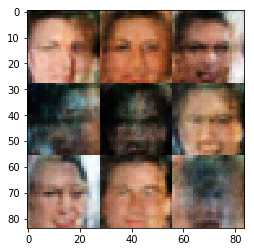

Epoch 1/1... Step: 4620: Discriminator Loss: 1.3891... Generator Loss: 0.7708
Epoch 1/1... Step: 4640: Discriminator Loss: 1.4143... Generator Loss: 0.8052
Epoch 1/1... Step: 4660: Discriminator Loss: 1.4064... Generator Loss: 0.7956
Epoch 1/1... Step: 4680: Discriminator Loss: 1.3797... Generator Loss: 0.7638
Epoch 1/1... Step: 4700: Discriminator Loss: 1.3745... Generator Loss: 0.7603


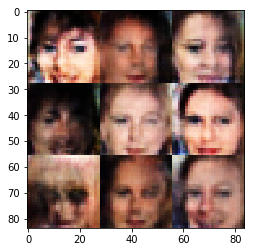

Epoch 1/1... Step: 4720: Discriminator Loss: 1.3967... Generator Loss: 0.7322
Epoch 1/1... Step: 4740: Discriminator Loss: 1.4273... Generator Loss: 0.7588
Epoch 1/1... Step: 4760: Discriminator Loss: 1.4317... Generator Loss: 0.7151
Epoch 1/1... Step: 4780: Discriminator Loss: 1.3877... Generator Loss: 0.7961
Epoch 1/1... Step: 4800: Discriminator Loss: 1.4073... Generator Loss: 0.7630


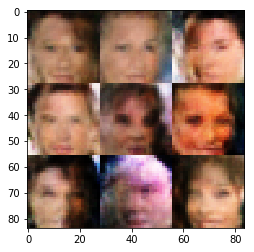

Epoch 1/1... Step: 4820: Discriminator Loss: 1.3896... Generator Loss: 0.7683
Epoch 1/1... Step: 4840: Discriminator Loss: 1.3815... Generator Loss: 0.7873
Epoch 1/1... Step: 4860: Discriminator Loss: 1.3761... Generator Loss: 0.8118
Epoch 1/1... Step: 4880: Discriminator Loss: 1.4127... Generator Loss: 0.7817
Epoch 1/1... Step: 4900: Discriminator Loss: 1.4205... Generator Loss: 0.7681


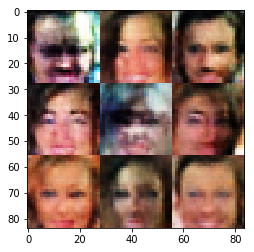

Epoch 1/1... Step: 4920: Discriminator Loss: 1.3831... Generator Loss: 0.7961
Epoch 1/1... Step: 4940: Discriminator Loss: 1.4139... Generator Loss: 0.7755
Epoch 1/1... Step: 4960: Discriminator Loss: 1.4029... Generator Loss: 0.7925
Epoch 1/1... Step: 4980: Discriminator Loss: 1.3859... Generator Loss: 0.7616
Epoch 1/1... Step: 5000: Discriminator Loss: 1.3712... Generator Loss: 0.7591


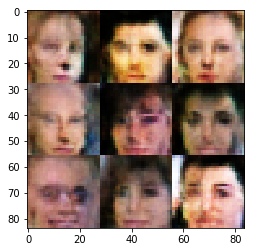

Epoch 1/1... Step: 5020: Discriminator Loss: 1.4075... Generator Loss: 0.8277
Epoch 1/1... Step: 5040: Discriminator Loss: 1.3988... Generator Loss: 0.7732
Epoch 1/1... Step: 5060: Discriminator Loss: 1.3821... Generator Loss: 0.7492
Epoch 1/1... Step: 5080: Discriminator Loss: 1.3984... Generator Loss: 0.8112
Epoch 1/1... Step: 5100: Discriminator Loss: 1.4050... Generator Loss: 0.7723


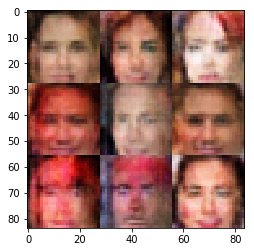

Epoch 1/1... Step: 5120: Discriminator Loss: 1.3966... Generator Loss: 0.8070
Epoch 1/1... Step: 5140: Discriminator Loss: 1.4141... Generator Loss: 0.7957
Epoch 1/1... Step: 5160: Discriminator Loss: 1.4045... Generator Loss: 0.7593
Epoch 1/1... Step: 5180: Discriminator Loss: 1.3806... Generator Loss: 0.7877
Epoch 1/1... Step: 5200: Discriminator Loss: 1.4045... Generator Loss: 0.7576


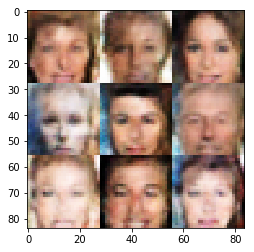

Epoch 1/1... Step: 5220: Discriminator Loss: 1.4216... Generator Loss: 0.8090
Epoch 1/1... Step: 5240: Discriminator Loss: 1.3650... Generator Loss: 0.7931
Epoch 1/1... Step: 5260: Discriminator Loss: 1.3699... Generator Loss: 0.7724
Epoch 1/1... Step: 5280: Discriminator Loss: 1.4048... Generator Loss: 0.8015
Epoch 1/1... Step: 5300: Discriminator Loss: 1.3734... Generator Loss: 0.7597


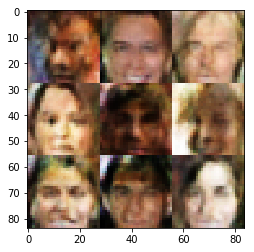

Epoch 1/1... Step: 5320: Discriminator Loss: 1.3744... Generator Loss: 0.7956
Epoch 1/1... Step: 5340: Discriminator Loss: 1.4225... Generator Loss: 0.7712
Epoch 1/1... Step: 5360: Discriminator Loss: 1.4322... Generator Loss: 0.7814
Epoch 1/1... Step: 5380: Discriminator Loss: 1.3858... Generator Loss: 0.8131
Epoch 1/1... Step: 5400: Discriminator Loss: 1.3926... Generator Loss: 0.7659


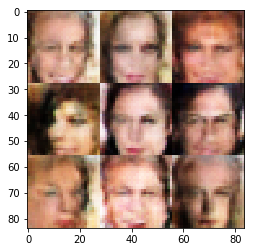

Epoch 1/1... Step: 5420: Discriminator Loss: 1.4182... Generator Loss: 0.7814
Epoch 1/1... Step: 5440: Discriminator Loss: 1.4160... Generator Loss: 0.7517
Epoch 1/1... Step: 5460: Discriminator Loss: 1.3954... Generator Loss: 0.7559
Epoch 1/1... Step: 5480: Discriminator Loss: 1.3925... Generator Loss: 0.7527
Epoch 1/1... Step: 5500: Discriminator Loss: 1.3727... Generator Loss: 0.7982


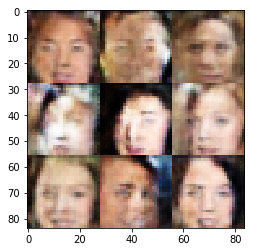

Epoch 1/1... Step: 5520: Discriminator Loss: 1.3931... Generator Loss: 0.7617
Epoch 1/1... Step: 5540: Discriminator Loss: 1.4190... Generator Loss: 0.7727
Epoch 1/1... Step: 5560: Discriminator Loss: 1.4025... Generator Loss: 0.7818
Epoch 1/1... Step: 5580: Discriminator Loss: 1.4040... Generator Loss: 0.7628
Epoch 1/1... Step: 5600: Discriminator Loss: 1.4323... Generator Loss: 0.7527


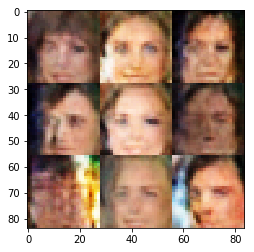

Epoch 1/1... Step: 5620: Discriminator Loss: 1.4133... Generator Loss: 0.8171
Epoch 1/1... Step: 5640: Discriminator Loss: 1.3789... Generator Loss: 0.7872
Epoch 1/1... Step: 5660: Discriminator Loss: 1.4257... Generator Loss: 0.7579
Epoch 1/1... Step: 5680: Discriminator Loss: 1.4229... Generator Loss: 0.7974
Epoch 1/1... Step: 5700: Discriminator Loss: 1.4117... Generator Loss: 0.7980


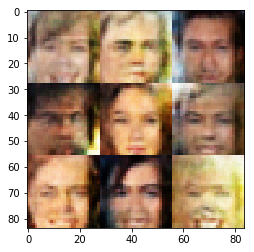

Epoch 1/1... Step: 5720: Discriminator Loss: 1.4106... Generator Loss: 0.7976
Epoch 1/1... Step: 5740: Discriminator Loss: 1.3758... Generator Loss: 0.7739
Epoch 1/1... Step: 5760: Discriminator Loss: 1.4127... Generator Loss: 0.7550
Epoch 1/1... Step: 5780: Discriminator Loss: 1.4047... Generator Loss: 0.7790
Epoch 1/1... Step: 5800: Discriminator Loss: 1.3895... Generator Loss: 0.7690


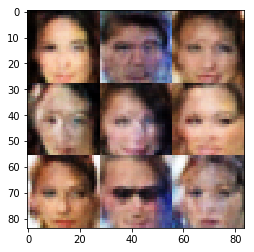

Epoch 1/1... Step: 5820: Discriminator Loss: 1.4439... Generator Loss: 0.7331
Epoch 1/1... Step: 5840: Discriminator Loss: 1.3986... Generator Loss: 0.7558
Epoch 1/1... Step: 5860: Discriminator Loss: 1.3872... Generator Loss: 0.7772
Epoch 1/1... Step: 5880: Discriminator Loss: 1.3844... Generator Loss: 0.8271
Epoch 1/1... Step: 5900: Discriminator Loss: 1.3829... Generator Loss: 0.7734


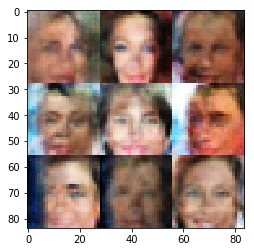

Epoch 1/1... Step: 5920: Discriminator Loss: 1.3867... Generator Loss: 0.7870
Epoch 1/1... Step: 5940: Discriminator Loss: 1.4054... Generator Loss: 0.7595
Epoch 1/1... Step: 5960: Discriminator Loss: 1.3769... Generator Loss: 0.7787
Epoch 1/1... Step: 5980: Discriminator Loss: 1.3996... Generator Loss: 0.7762
Epoch 1/1... Step: 6000: Discriminator Loss: 1.3728... Generator Loss: 0.7933


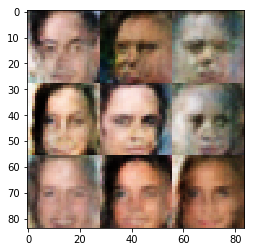

Epoch 1/1... Step: 6020: Discriminator Loss: 1.3742... Generator Loss: 0.8168
Epoch 1/1... Step: 6040: Discriminator Loss: 1.4072... Generator Loss: 0.8088
Epoch 1/1... Step: 6060: Discriminator Loss: 1.4072... Generator Loss: 0.7739
Epoch 1/1... Step: 6080: Discriminator Loss: 1.3667... Generator Loss: 0.7762
Epoch 1/1... Step: 6100: Discriminator Loss: 1.4098... Generator Loss: 0.7752


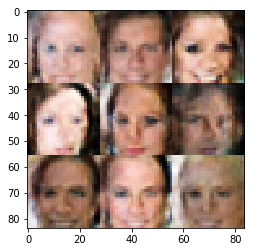

Epoch 1/1... Step: 6120: Discriminator Loss: 1.4026... Generator Loss: 0.7808
Epoch 1/1... Step: 6140: Discriminator Loss: 1.3998... Generator Loss: 0.7792
Epoch 1/1... Step: 6160: Discriminator Loss: 1.3899... Generator Loss: 0.7512
Epoch 1/1... Step: 6180: Discriminator Loss: 1.4058... Generator Loss: 0.7771
Epoch 1/1... Step: 6200: Discriminator Loss: 1.3980... Generator Loss: 0.8124


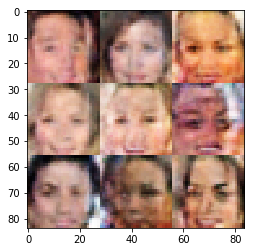

Epoch 1/1... Step: 6220: Discriminator Loss: 1.3958... Generator Loss: 0.7742
Epoch 1/1... Step: 6240: Discriminator Loss: 1.3846... Generator Loss: 0.7940
Epoch 1/1... Step: 6260: Discriminator Loss: 1.3855... Generator Loss: 0.7590
Epoch 1/1... Step: 6280: Discriminator Loss: 1.4069... Generator Loss: 0.7690
Epoch 1/1... Step: 6300: Discriminator Loss: 1.4004... Generator Loss: 0.8028


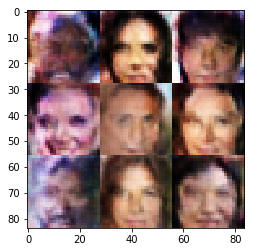

Epoch 1/1... Step: 6320: Discriminator Loss: 1.3581... Generator Loss: 0.8195


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.